In [25]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [27]:
count = 0
dirs = os.listdir(r'Train_Data_Tubes')
for dir in dirs:
    files = list(os.listdir(r'Train_Data_Tubes/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

Gandum Folder has 101 Images
Sorgum Folder has 101 Images
Beras Folder has 101 Images
Images Folder has 303 Images


In [28]:
# Parameter
base_dir = r'Train_Data_Tubes' 
img_size = 180 
batch = 32 
validation_split = 0.1

In [29]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123, 
    image_size=(img_size, img_size),
    batch_size=batch,
)

Found 310 files belonging to 3 classes.


In [30]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Beras', 'Gandum', 'Sorgum']


In [31]:
total_count =len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 10
Train Images: 9
Validation Images: 1


In [32]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

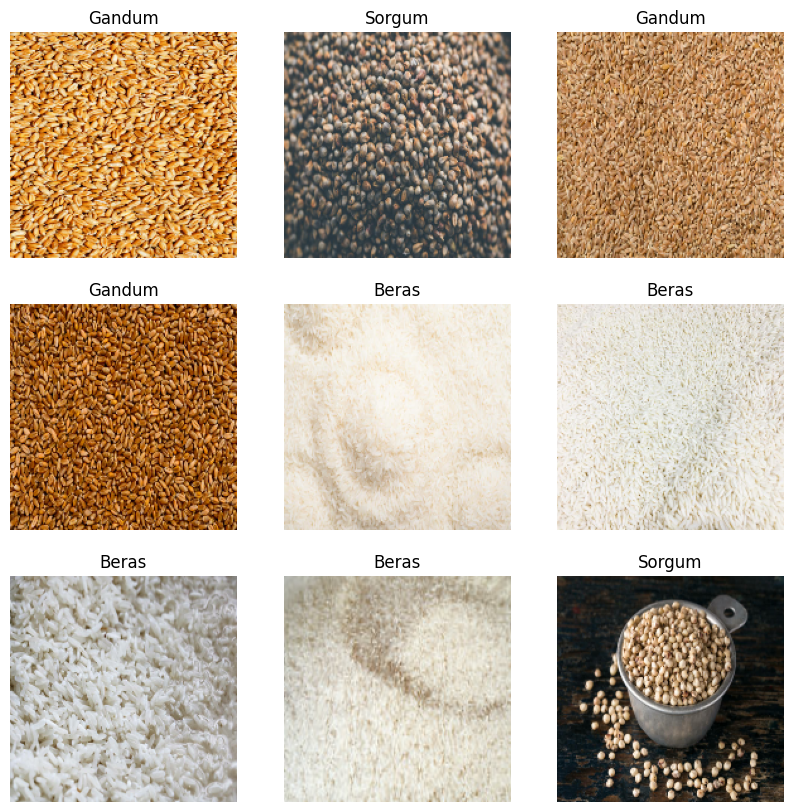

In [33]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]]) 
    plt.axis('off')

In [34]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(32, 180, 180, 3)


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

In [36]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [37]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [38]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1) 
])

/opt/tljh/user/envs/dltf/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


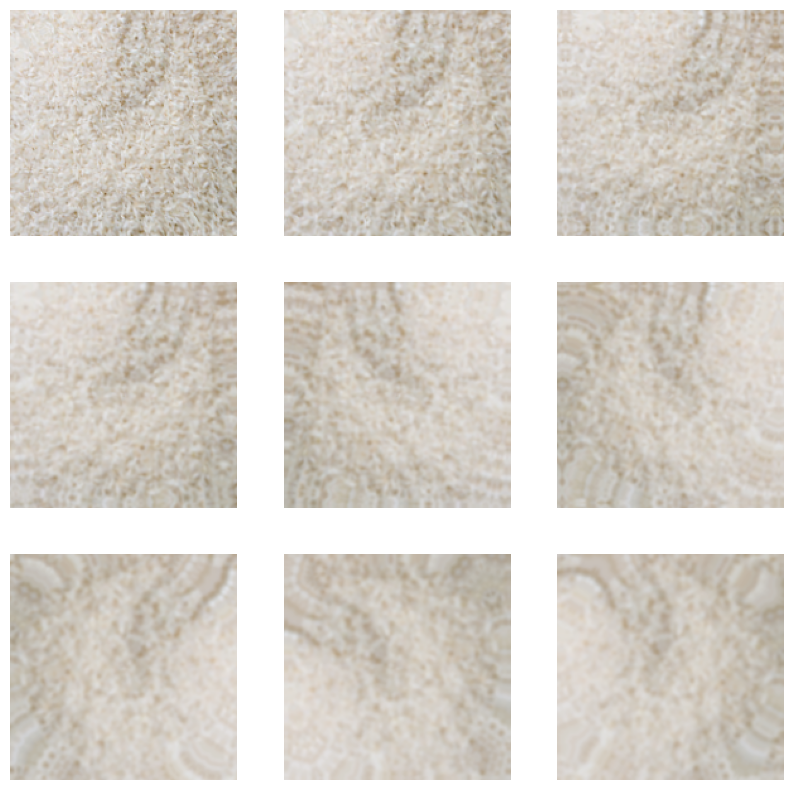

In [39]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [40]:
from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.models import Model 

base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))

base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])


/tmp/ipykernel_2823050/952645268.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))


In [41]:
from tensorflow.keras.optimizers import Adam 

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,451 (12.82 MB)

 Trainable params: 3,069,443 (11.71 MB)

 Non-trainable params: 291,008 (1.11 MB)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               mode='max')

history= model.fit(train_ds,
                   epochs=50,
                   validation_data=val_ds,
                   callbacks=[early_stopping])

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.5556 - loss: 0.9623 - val_accuracy: 0.6364 - val_loss: 0.7106
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8904 - loss: 0.3034 - val_accuracy: 0.8182 - val_loss: 0.4587
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9603 - loss: 0.1270 - val_accuracy: 0.8636 - val_loss: 0.2982
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9727 - loss: 0.0760 - val_accuracy: 0.9091 - val_loss: 0.2101
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9752 - loss: 0.0795 - val_accuracy: 0.9545 - val_loss: 0.1805
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9893 - loss: 0.0465 - val_accuracy: 0.9545 - val_loss: 0.1653
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9894 - loss: 0.0377 - val_accuracy: 0.9545 - val_loss: 0.1091
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9953 - loss: 0.0253 - val_accuracy: 0.9545 - val_loss:

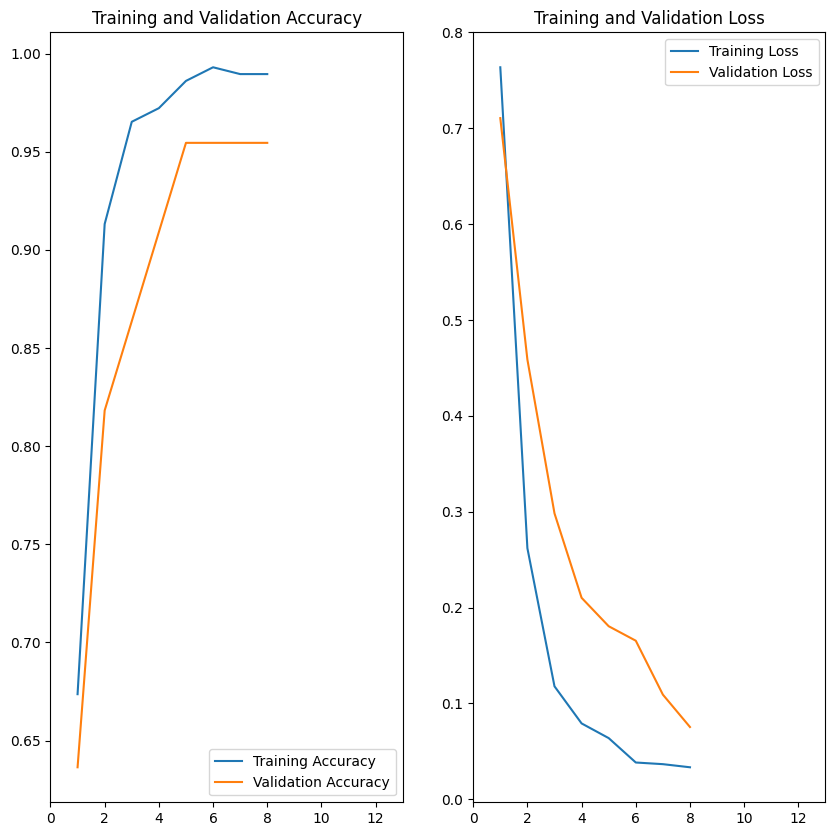

In [44]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1) 
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right') 
plt.xlim(0, 13) 
plt.title('Training and Validation Accuracy') 

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [45]:
model.save('Model_MobileNet.h5')

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model(r'Model_MobileNet.h5')
class_names = ['Beras', 'Gandum', 'Sorgum']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image) 
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'Train_Data_Tubes/Beras/Beras 99.jpg', save_path='Beras2.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Prediksi: Beras
Confidence: 57.61%
Prediksi: Beras dengan confidence 57.61%. Gambar asli disimpan di Beras2.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


2024-12-20 01:28:04.693149: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


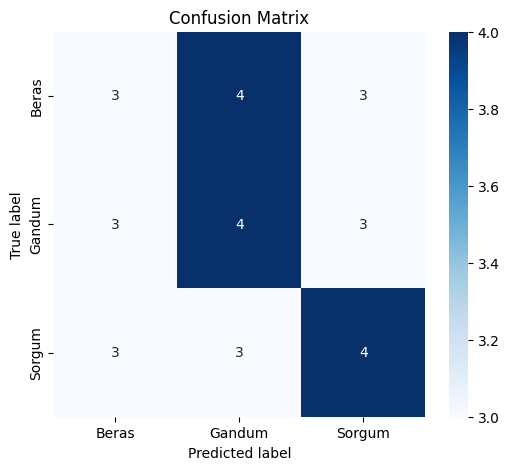

Confusion Matrix:
 [[3 4 3]
 [3 4 3]
 [3 3 4]]
Akurasi: 0.36666666666666664
Presisi: [0.33333333 0.36363636 0.4       ]
Recall: [0.3 0.4 0.4]
F1 Score: [0.31578947 0.38095238 0.4       ]


In [55]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

mobileNet_model = load_model(r'Model_MobileNet.h5')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'Test_Data_Tubes',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(180, 180)
)

y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)

true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Beras", "Gandum", "Sorgum"],
            yticklabels=["Beras", "Gandum", "Sorgum"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
